In [31]:
from matplotlib import pyplot as plt
%matplotlib inline
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
warnings.filterwarnings("ignore")

In [32]:
# place = pd.read_csv('../Data/whyout_data/place.csv') # shape(4697,10), place idx에서 23개가 비어있음
# product = pd.read_csv('../Data/whyout_data/product.csv') # shape(5834,11), product idx에서 538개가 비어있음
# video = pd.read_csv('../Data/whyout_data/video.csv') # shape(3250, 9), video idx에서 315개가 비어있음

In [33]:
index_null_del_user_place = pd.read_csv('../Data/whyout_data/index_null_del_user_place.csv', index_col=0).astype(dtype='float16')
index_null_del_user_product = pd.read_csv('../Data/whyout_data/index_null_del_user_product.csv', index_col=0).astype(dtype='float16')
index_null_del_user_video = pd.read_csv('../Data/whyout_data/index_null_del_user_video.csv', index_col=0).astype(dtype='float16')

In [34]:
class MatrixFactorization():
    def __init__(self, R, k, learning_rate, reg_param, epochs, verbose=False):
        """
        :param R: rating matrix
        :param k: latent parameter
        :param learning_rate: alpha on weight update
        :param reg_param: beta on weight update
        :param epochs: training epochs
        :param verbose: print status
        """
        self._R = R
        self._num_users, self._num_items = R.shape
        self._k = k
        self._learning_rate = learning_rate
        self._reg_param = reg_param
        self._epochs = epochs
        self._verbose = verbose
        self.cost_list = []


    def fit(self):
        """
        training Matrix Factorization : Update matrix latent weight and bias

        참고: self._b에 대한 설명
        - global bias: input R에서 평가가 매겨진 rating의 평균값을 global bias로 사용
        - 정규화 기능. 최종 rating에 음수가 들어가는 것 대신 latent feature에 음수가 포함되도록 해줌.

        :return: training_process
        """
        # init latent features
        self._U = np.random.normal(size=(self._num_users, self._k))
        self._V = np.random.normal(size=(self._num_items, self._k))

        # init biases
        self._b_U = np.zeros(self._num_users)
        self._b_V = np.zeros(self._num_items)
        self._b = np.mean(self._R[np.where(self._R != 0)])

        # train while epochs
        self._training_process = []
        for epoch in range(self._epochs):
            # rating이 존재하는 index를 기준으로 training
            xi, yi = self._R.nonzero()
            for i, j in zip(xi, yi):
                self.gradient_descent(i, j, self._R[i, j])
            cost = self.cost()
            self._training_process.append((epoch, cost))

            # print status
            if self._verbose == True and ((epoch + 1) % 10 == 0):
                self.cost_list.append(cost)
                print("Iteration: %d ; cost = %.4f" % (epoch + 1, cost))
        return self.cost_list


    def cost(self):
        """
        compute root mean square error
        :return: rmse cost
        """
        # xi, yi: R[xi, yi]는 nonzero인 value를 의미한다.
        xi, yi = self._R.nonzero()
        # predicted = self.get_complete_matrix()
        cost = 0
        for x, y in zip(xi, yi):
            cost += pow(self._R[x, y] - self.get_prediction(x, y), 2)
        return np.sqrt(cost/len(xi))


    def gradient(self, error, i, j):
        """
        gradient of latent feature for GD
        :param error: rating - prediction error
        :param i: user index
        :param j: item index
        :return: gradient of latent feature tuple
        """
        du = (error * self._V[j, :]) - (self._reg_param * self._U[i, :]) # user에 대해 gradient -> item에 대해 미분
        dv = (error * self._U[i, :]) - (self._reg_param * self._V[j, :])
        return du, dv


    def gradient_descent(self, i, j, rating):
        """
        graident descent function
        :param i: user index of matrix
        :param j: item index of matrix
        :param rating: rating of (i,j)
        """
        # get error
        prediction = self.get_prediction(i, j)
        error = rating - prediction

        # update biases
        self._b_U[i] += self._learning_rate * (error - self._reg_param * self._b_U[i])
        self._b_V[j] += self._learning_rate * (error - self._reg_param * self._b_V[j])

        # update latent feature
        du, dv = self.gradient(error, i, j)
        self._U[i, :] += self._learning_rate * du
        self._V[j, :] += self._learning_rate * dv


    def get_prediction(self, i, j):
        """
        get predicted rating: user_i, item_j
        :return: prediction of r_ij
        """
        return self._b + self._b_U[i] + self._b_V[j] + self._U[i, :].dot(self._V[j, :].T)


    def get_complete_matrix(self):
        """
        computer complete matrix UXV + U.bias + V.bias + global bias

        - UXV 행렬에 b_U[:, np.newaxis]를 더하는 것은 각 열마다 bias를 더해주는 것
        - b_V[np.newaxis:, ]를 더하는 것은 각 행마다 bias를 더해주는 것
        - b를 더하는 것은 각 element마다 bias를 더해주는 것

        - newaxis: 차원을 추가해줌. 1차원인 Latent들로 2차원의 R에 행/열 단위 연산을 해주기위해 차원을 추가하는 것.

        :return: complete matrix R^
        """
        return self._b + self._b_U[:, np.newaxis] + self._b_V[np.newaxis:, ] + self._U.dot(self._V.T)
    
    def print_results(self):
        print("User Latent U:")
        print(self._U)
        print("Item Latent V:")
        print(self._V.T)
        print("U x V:")
        print(self._U.dot(self._V.T))
        print("bias:")
        print(self._b)
        print("User Latent bias:")
        print(self._b_U)
        print("Item Latent bias:")
        print(self._b_V)
        print("Final R matrix:")
        print(self.get_complete_matrix())
        print("Final RMSE:")
        print(self._training_process[self._epochs-1][1])


if __name__ == "__main__":
    # rating matrix - User X Item : (25827 X 4697)
    # U, V is (25827 X k), (k X 4697) matrix
    R = np.array(index_null_del_user_place)
    factorizer = MatrixFactorization(R, k=50, learning_rate=0.01, reg_param=0.01, epochs=2000, verbose=True)
    cost_list = factorizer.fit()
    complete_matrix = factorizer.get_complete_matrix()

    R1 = np.array(index_null_del_user_product)
    factorizer = MatrixFactorization(R1, k=50, learning_rate=0.01, reg_param=0.01, epochs=2000, verbose=True)
    cost_list1 = factorizer.fit()
    complete_matrix1 = factorizer.get_complete_matrix()

    R2 = np.array(index_null_del_user_video)
    factorizer = MatrixFactorization(R2, k=50, learning_rate=0.01, reg_param=0.01, epochs=2000, verbose=True)
    cost_list2 = factorizer.fit()
    complete_matrix2 = factorizer.get_complete_matrix()

Iteration: 10 ; cost = 0.7636
Iteration: 20 ; cost = 0.7367
Iteration: 30 ; cost = 0.7166
Iteration: 40 ; cost = 0.6972
Iteration: 50 ; cost = 0.6768
Iteration: 60 ; cost = 0.6551
Iteration: 70 ; cost = 0.6319
Iteration: 80 ; cost = 0.6074
Iteration: 90 ; cost = 0.5819
Iteration: 100 ; cost = 0.5559
Iteration: 110 ; cost = 0.5298
Iteration: 120 ; cost = 0.5040
Iteration: 130 ; cost = 0.4791
Iteration: 140 ; cost = 0.4552
Iteration: 150 ; cost = 0.4327
Iteration: 160 ; cost = 0.4116
Iteration: 170 ; cost = 0.3921
Iteration: 180 ; cost = 0.3742
Iteration: 190 ; cost = 0.3579
Iteration: 200 ; cost = 0.3431
Iteration: 210 ; cost = 0.3298
Iteration: 220 ; cost = 0.3178
Iteration: 230 ; cost = 0.3071
Iteration: 240 ; cost = 0.2976
Iteration: 250 ; cost = 0.2891
Iteration: 260 ; cost = 0.2816
Iteration: 270 ; cost = 0.2750
Iteration: 280 ; cost = 0.2690
Iteration: 290 ; cost = 0.2637
Iteration: 300 ; cost = 0.2589
Iteration: 310 ; cost = 0.2546
Iteration: 320 ; cost = 0.2507
Iteration: 330 ; 

In [ ]:
def recommend_items(user_id, recommendation_num, item, R):
    """
    사용자에게 아이템을 추천하는 함수
    
    :param user_id: 사용자 인덱스
    :param recommendation_num: 추천할 아이템 개수
    :param item: 예측된 평점 행렬
    :param R: 실제 사용자 평점 행렬
    :return: 추천된 아이템 인덱스 리스트
    """
    user_ratings = R[user_id, :]  # 해당 사용자의 평가 데이터
    predictions = item[user_id, :]  # 모델의 예측 점수

    # 사용자가 이미 평가한 아이템은 -inf로 설정하여 추천 대상에서 제외
    recommended_items = np.where(user_ratings != 0, -np.inf, predictions)

    # 예측 점수가 가장 높은 상위 n개 아이템 추천
    top_recommended_item_indices = np.argsort(recommended_items)[-recommendation_num:][::-1]

    return top_recommended_item_indices

In [ ]:
# df = pd.DataFrame(complete_matrix)
# df.to_csv('complete_matrix_place.csv')

In [ ]:
sgd_place_df = pd.read_csv('../Data/whyout_data/sgd_result/complete_matrix_place.csv', index_col=0)
sgd_product_df = pd.read_csv('../Data/whyout_data/sgd_result/complete_matrix_product.csv', index_col=0)
sgd_video_df = pd.read_csv('../Data/whyout_data/sgd_result/complete_matrix_video.csv', index_col=0)
place_item = np.array(sgd_place_df)
product_item = np.array(sgd_product_df)
video_item = np.array(sgd_video_df)
R_place = np.array(index_null_del_user_place)
R_product = np.array(index_null_del_user_product)
R_video = np.array(index_null_del_user_video)

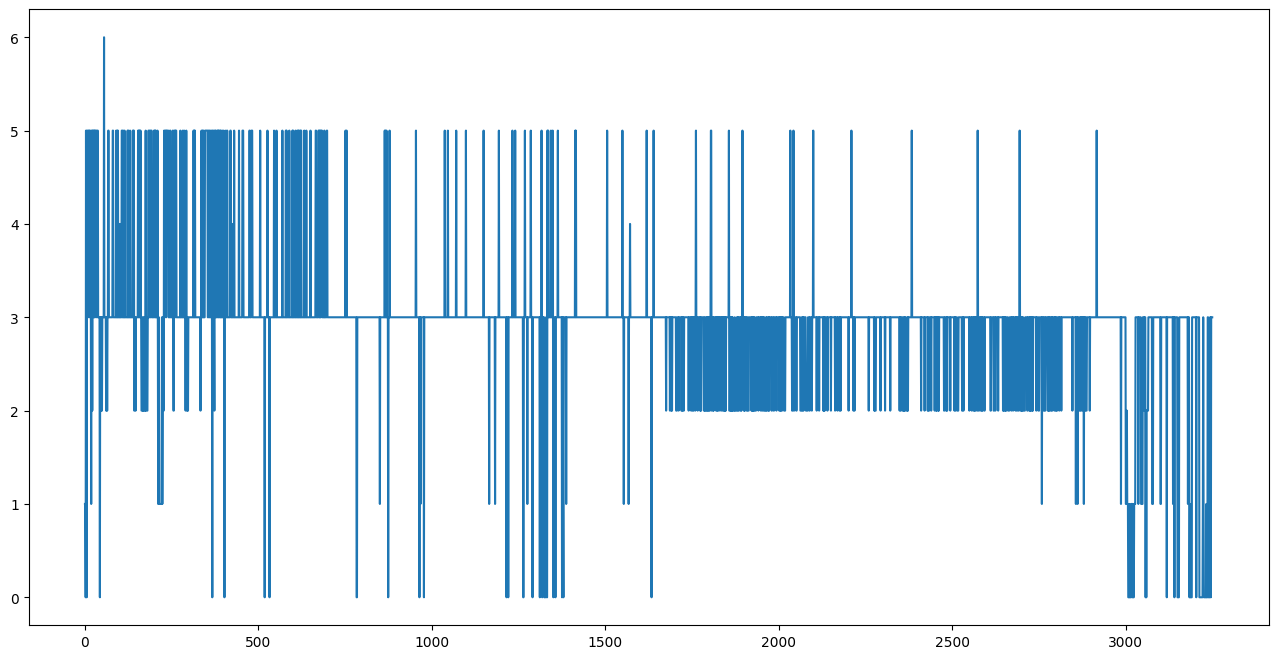

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(index_null_del_user_video.max().values)

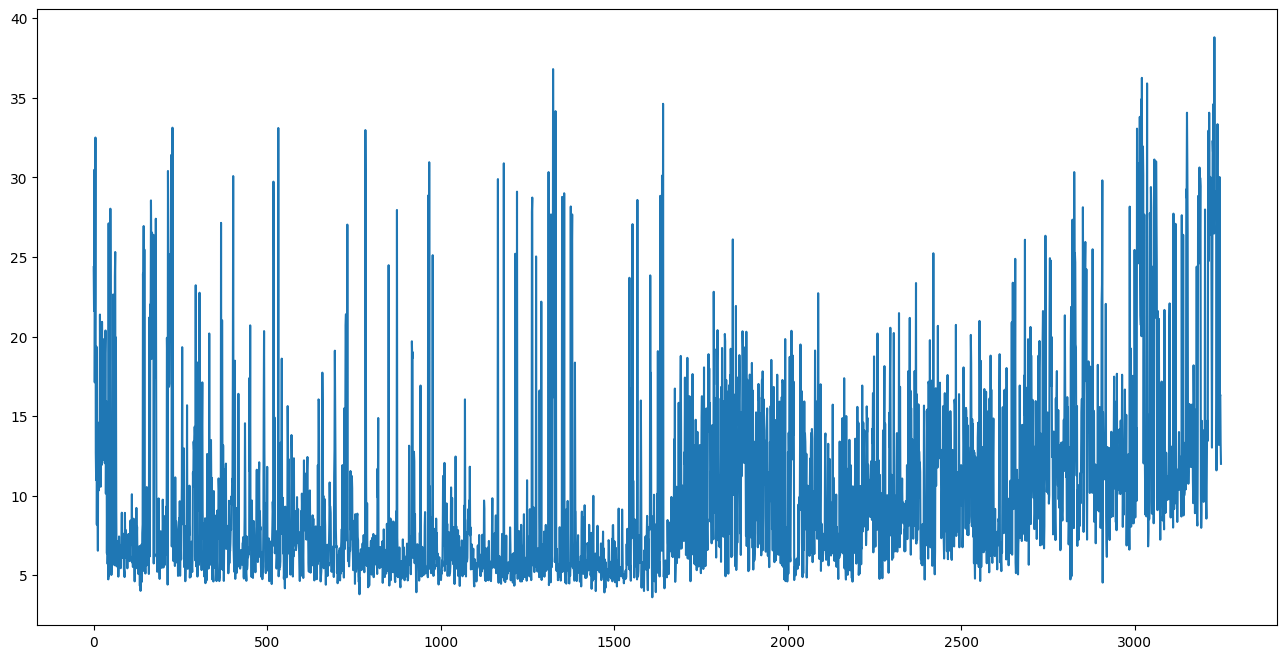

In [ ]:
plt.figure(figsize=(16,8))
plt.plot(sgd_video_df.max().values)

In [ ]:
# 사용자 선택
user_id = 2
recommendation_num = 10
item = [place_item, product_item, video_item]
R = [R_place, R_product, R_video]

top_recommended_item_indices = recommend_items(user_id, recommendation_num, item[0], R[0])

print(f"user {user_id}에게 추천해줄 {recommendation_num}개 아이템 id : {top_recommended_item_indices}")

user 2에게 추천해줄 10개 아이템 id : [1025 4498 1565 1439  586 4363  810 1477 1284 2581]
